Library import and data loading 

In [307]:


if 'libraries_imported' not in globals():
    libraries_imported = False

if not libraries_imported:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from datetime import datetime, timedelta

    # Plotly libraries
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.io as pio

    # SciPy libraries
    from scipy.interpolate import make_interp_spline
    from scipy.signal import butter, filtfilt

    # TensorFlow and Keras for neural networks
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.regularizers import l1_l2
    from tensorflow.keras.models import load_model

    # Scikit-learn for model preparation and evaluation
    from sklearn.model_selection import train_test_split, KFold, GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_absolute_error

    # Ensemble and boosting models
    from xgboost import XGBRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.tree import DecisionTreeRegressor

    # Additional utilities
    import logging
    import joblib 
    import matplotlib.dates as mdates


        


    logging.getLogger('tensorflow').setLevel(logging.ERROR)

    # Optionally, to suppress absl (used by TensorFlow) messages as well:
    from absl import logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)


    # Placeholder for DataFrame
    df_annotations = None

    # Set plot size for Seaborn
    sns.set(rc={'figure.figsize':(17,8.27)})

    # Set the flag to True to indicate libraries are imported
    libraries_imported = True

# Set plot size for Seaborn (outside the if condition)
sns.set(rc={'figure.figsize':(17,8.27)})


Functions 

In [308]:

def apply_fig_format(fig_x, w=2000, h=600, subplot=False, n_cols=1, n_rows=1):
    xaxis_args=dict(
            tickfont=dict(size=18),
            title_font=dict(size=22),
            gridcolor='lightgray',
            linecolor='gray',
            linewidth=1,
            mirror=True,
            showline=True,
            dtick='D'
        )
    yaxis_args=dict(
            tickfont=dict(size=18),
            title_font=dict(size=22),
            gridcolor='lightgray',
            linecolor='gray',
            linewidth=1,
            mirror=True,
            showline=True,
        )

    fig_x.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        width=w,
        height=h,
     )

    if subplot:
        for i in range(1, n_cols*n_rows+1):
            fig_x['layout']['xaxis'+str(i)].update(xaxis_args)
            fig_x['layout']['yaxis'+str(i)].update(yaxis_args)
    else:
        fig_x['layout']['xaxis'].update(xaxis_args)
        fig_x['layout']['yaxis'].update(yaxis_args)




    fig_x.show()


def apply_date_range_df(df):
  df = df[df['datetime'].dt.date >= date_start]
  df = df[df['datetime'].dt.date <= date_end]
  return df

In [309]:



def preprocess_dataframe(df, columns_to_drop):
    # Interpolate missing values
    df_interpolated = df.interpolate(method='linear')
    df_interpolated_bfilled = df_interpolated.bfill()

    # Drop unnecessary columns
    df_preprocessed = df_interpolated_bfilled.drop(columns=columns_to_drop)

    # Convert 'datetime' to datetime object and set it as index
    df_preprocessed['datetime'] = pd.to_datetime(df_preprocessed['datetime'])
    df_preprocessed = df_preprocessed.groupby('datetime').mean()

    # Create lagged features
    df_preprocessed['A Current_daily_avg_lag1d_dt'] = df_preprocessed['A Current_daily_avg'].shift(freq='1D')
    df_preprocessed['ntp_volume_this_tip_intervalml_daily_avg_lag1d_dt'] = df_preprocessed['ntp_volume_this_tip_intervalml_daily_avg'].shift(freq='1D')

    # Backfill any remaining missing values
    df_preprocessed = df_preprocessed.bfill()

    # Reset the index
    df_preprocessed.reset_index(inplace=True)
    
    return df_preprocessed

# Load your datasets
test_df = pd.read_csv('live_implementation_data.csv')
original_dataset = pd.read_csv('complete_data.csv')

# Columns to drop
columns_to_drop = ['TSS', 'COD_kg/m3', 'VS', 'TE', 'TS', 'sample_vol', 'index', 'VFA', 'Unnamed: 0', 'CH4%', 'CO2', 'H2S']

# Apply preprocessing
original_dataset = preprocess_dataframe(original_dataset, columns_to_drop)
test_dataset = preprocess_dataframe(test_df, columns_to_drop)









df = test_dataset.copy()
date_series = df['datetime'].dt.date
date_list = date_series.tolist()
unique_dates = list(set(date_list))
sorted_unique_dates = sorted(unique_dates)
print(sorted_unique_dates)









combined_dataset = pd.concat([original_dataset, test_dataset.sample(frac=0.3)])
# combined_df = pd.concat([original_dataset, test_dataset.sample(frac=0.2)])

# num_rows = int(len(test_dataset) * 0.5)
# first_20_percent = test_dataset.iloc[:num_rows]
# combined_df = pd.concat([original_dataset, first_20_percent])



combined_df = combined_dataset.copy()
combined_df.drop(columns=['datetime'], inplace=True)  

# Prepare combined dataset for model training
X_combined = combined_df.drop(['sCOD_kg/m3'], axis=1)  # Assuming 'VS' is the target variable
y_combined = combined_df['sCOD_kg/m3']

# Scale features
scaler = StandardScaler().fit(X_combined)
X_combined_scaled = scaler.transform(X_combined)



X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.4, random_state=20)

# Scale features (fit on training data only)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
best_model = load_model('my_model.h5')

best_model.fit(X_train_scaled, y_train)

# Validate on the newly created validation set
y_pred_val = best_model.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_pred_val)


print(f'Mean Absolute Error on Validation Set: {mae}')
test_dataset.drop(columns=['datetime'], inplace=True) 
X_test_new = scaler.transform(test_dataset.drop(['sCOD_kg/m3', 'datetime'], axis=1, errors='ignore')) 
y_pred = best_model.predict(X_test_new)
test_dataset.reset_index(inplace=True)







[datetime.date(2024, 1, 27), datetime.date(2024, 1, 28), datetime.date(2024, 1, 29), datetime.date(2024, 1, 30), datetime.date(2024, 1, 31), datetime.date(2024, 2, 1), datetime.date(2024, 2, 2), datetime.date(2024, 2, 3), datetime.date(2024, 2, 4)]


61/61 [==============================] - 0s 397us/step
Mean Absolute Error on Validation Set: 0.715034974814389
37/37 [==============================] - 0s 628us/step


In [310]:
y_pred = y_pred.flatten().tolist()

trace1 = go.Scatter(
    x= df['datetime'],
    y=y_pred,
    mode='markers',
    marker=dict(color='blue', symbol='x'),
    name='Predicted',
    opacity=0.5
)

trace2 = go.Scatter(
    x= df['datetime'],
    y=test_dataset['sCOD_kg/m3'],
    mode='markers',
    marker=dict(color='red', symbol='circle'),
    name='Actual',
    opacity=0.5
)

# Create the figure
fig = go.Figure(data=[trace1, trace2])

# Update layout
fig.update_layout(
    title='Predicted sCOD over Time',
    xaxis_title='Datetime',
    yaxis_title= 'sCOD_kg/m3',
    xaxis=dict(
        # Uncomment and adjust the line below for datetime formatting, if needed
        # tickformat='%Y-%m-%d', 
        # tickmode='auto',  # or 'array', with tickvals and ticktext
    ),
    legend=dict(y=1, x=1),
    hovermode='closest',
    template='plotly',  # Choose a template as per your preference
    width=1200,  # Adjust the size as needed
    height=700
)



apply_fig_format(fig, 1200, 600)







In [311]:
new_data = pd.read_csv('last7days.csv')
new_data_processed = preprocess_dataframe(new_data, columns_to_drop)

date_series_new = new_data_processed['datetime'].dt.date
unique_dates_new = list(set(date_series_new))
sorted_unique_dates = sorted(unique_dates_new)


# Initialize dataframe for tracking predictions
tracking_df = pd.DataFrame(columns=['day', 'real', 'pred', 'working'])

# Iterate over each day in the new data
for day in sorted_unique_dates:
    # Extract day's data
    day_data = new_data_processed[new_data_processed['datetime'].dt.date == day]

    # Check if day_data is empty
    if day_data.empty:
        print(f"No data available for {day}, skipping this date.")
        continue

    # Drop 'datetime' and target column for prediction
    X_day = day_data.drop(['sCOD_kg/m3', 'datetime'], axis=1, errors='ignore')
    X_day_scaled = scaler.transform(X_day)

    # Predict using the model
    prediction = best_model.predict(X_day_scaled)

    # Get the real value
    real_value = day_data['sCOD_kg/m3'].values

    # Update the tracking dataframe
    tracking_df = tracking_df.append({'day': day, 'real': real_value, 'pred': prediction, 'working': prediction}, ignore_index=True)


    display(tracking_df.head())

    # Every second day, retrain the model
    if tracking_df.shape[0] % 2 == 0:
        # Combine the datasets for retraining
        combined_for_retraining = pd.concat([original_dataset, new_data_processed[new_data_processed['datetime'].dt.date <= day]])
        combined_for_retraining.drop(columns=['datetime'], inplace=True)

        # Prepare dataset for retraining
        X_retrain = combined_for_retraining.drop(['sCOD_kg/m3'], axis=1)
        y_retrain = combined_for_retraining['sCOD_kg/m3']

        # Scale features for retraining
        X_retrain_scaled = scaler.transform(X_retrain)

        # Retrain the model
        best_model.fit(X_retrain_scaled, y_retrain)

        # Save the retrained model
        best_model.save(f'model_directory/model_day_{day}.h5')

display(tracking_df)

5/5 [==============================] - 0s 904us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."


5/5 [==============================] - 0s 3ms/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."


5/5 [==============================] - 0s 938us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."


5/5 [==============================] - 0s 814us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."


5/5 [==============================] - 0s 1ms/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


5/5 [==============================] - 0s 846us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


5/5 [==============================] - 0s 866us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


5/5 [==============================] - 0s 704us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


5/5 [==============================] - 0s 690us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


5/5 [==============================] - 0s 1ms/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


5/5 [==============================] - 0s 777us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


5/5 [==============================] - 0s 932us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


5/5 [==============================] - 0s 864us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


5/5 [==============================] - 0s 815us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


5/5 [==============================] - 0s 718us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


5/5 [==============================] - 0s 709us/step


/tmp/ipykernel_98336/117255612.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."


212/212 [==============================] - 0s 587us/step - loss: 0.6065


,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[28.579504], [28.583216], [28.59029], [28.595...","[[28.579504], [28.583216], [28.59029], [28.595..."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[[29.592415], [29.59556], [29.599213], [29.604...","[[29.592415], [29.59556], [29.599213], [29.604..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[[27.259724], [27.253437], [27.247017], [27.24...","[[27.259724], [27.253437], [27.247017], [27.24..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[[25.5894], [25.578003], [25.56781], [25.55073...","[[25.5894], [25.578003], [25.56781], [25.55073..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[[26.192396], [26.191412], [26.18791], [26.186...","[[26.192396], [26.191412], [26.18791], [26.186..."
5,2024-02-09,"[26.065369649805447, 26.060700389105058, 26.05...","[[25.20262], [25.180635], [25.166815], [25.153...","[[25.20262], [25.180635], [25.166815], [25.153..."
6,2024-02-10,"[25.654020100502514, 25.655695142378562, 25.65...","[[24.63653], [24.632118], [24.626896], [24.623...","[[24.63653], [24.632118], [24.626896], [24.623..."
7,2024-02-11,"[25.836180904522614, 25.837018425460638, 25.83...","[[23.272564], [23.247114], [23.222599], [23.19...","[[23.272564], [23.247114], [23.222599], [23.19..."
8,2024-02-12,"[26.018341708542714, 26.020016750418762, 26.02...","[[24.345146], [24.342537], [24.340937], [24.33...","[[24.345146], [24.342537], [24.340937], [24.33..."
9,2024-02-13,"[29.495642201834862, 29.553440366972477, 29.61...","[[22.400167], [22.379448], [22.340466], [22.31...","[[22.400167], [22.379448], [22.340466], [22.31..."


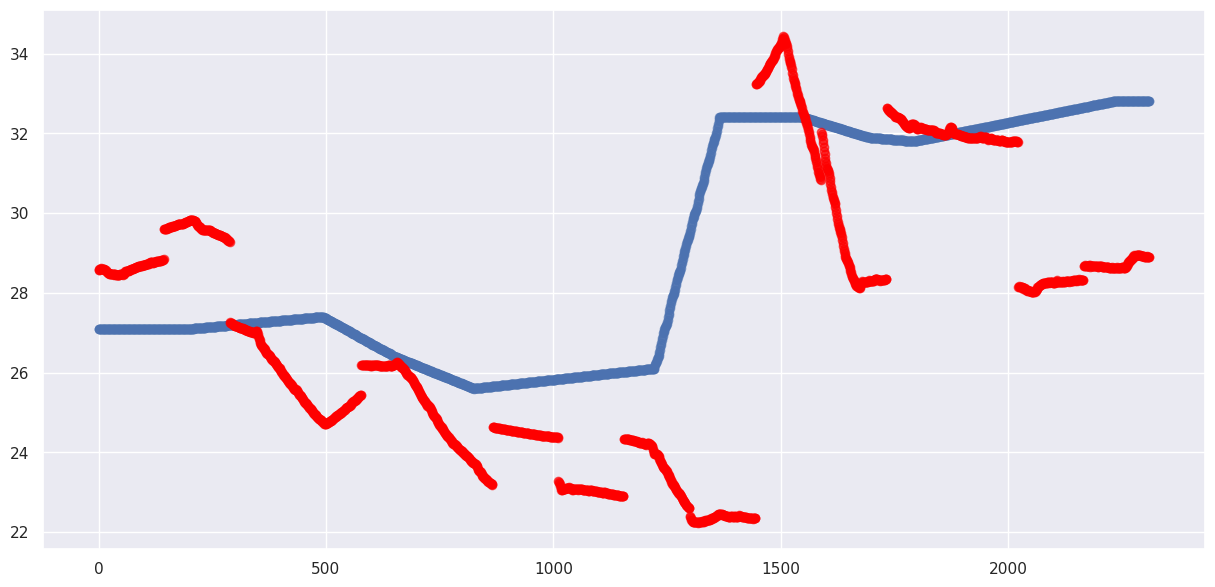

In [312]:
expanded_rows = []
tracking_df['day'] = pd.to_datetime(tracking_df['day'])
for index, row in tracking_df.iterrows():
    day = row['day']
    real_values = row['real']
    pred_values = row['pred']  # Directly use pred values assuming they are not nested
    for real, pred in zip(real_values, pred_values):
        expanded_rows.append({'day': day, 'real': real, 'pred': pred[0]})  # Ensure pred is correctly indexed

expanded_df = pd.DataFrame(expanded_rows)

# Step 2: Plot the expanded DataFrame
plt.figure(figsize=(15, 7))

# Using scatter plot for individual observations
plt.scatter(range(len(expanded_df)), expanded_df['real'], label='Real Value', alpha=0.6)
plt.scatter(range(len(expanded_df)), expanded_df['pred'], label='Predicted Value', alpha=0.6, color='red')

tracking_df['real_avg'] = tracking_df['real'].apply(lambda x: sum(x) / len(x))

In [313]:


# Assuming preprocess_dataframe and columns_to_drop are defined elsewhere
# Example: new_data_processed = preprocess_dataframe(new_data, columns_to_drop)

update_frequency = 50

new_data = pd.read_csv('last7days.csv')
# Assuming datetime conversion and preprocessing are done within preprocess_dataframe
new_data_processed = preprocess_dataframe(new_data, columns_to_drop)

# Load the initial model
model = load_model('my_model.h5')

# Initialize tracking dataframe
tracking_df = pd.DataFrame(columns=['day', 'real', 'pred', 'working'])

# Assume scaler is defined and fit to your initial training set elsewhere
# scaler = StandardScaler()

tracking_df_list = []  # Use a list to collect data for efficiency

for i, day in enumerate(sorted(set(new_data_processed['datetime'].dt.date))):

    print('day is', day, i)
    day_data = new_data_processed[new_data_processed['datetime'].dt.date == day]
    if day_data.empty:
        print(f"No data available for {day}, skipping.")
        continue

    X_day = day_data.drop(['datetime', 'sCOD_kg/m3'], axis=1)
    y_day = day_data['sCOD_kg/m3']
    X_day_scaled = scaler.transform(X_day)
    predictions = model.predict(X_day_scaled)

    # Determine 'working' data based on the retrain rate as a frequency
    working_data = y_day.tolist() if i % update_frequency == 0 else predictions.flatten().tolist()

    tracking_df_list.append({
        'day': day, 
        'real': y_day.tolist(), 
        'pred': predictions.flatten().tolist(), 
        'working': working_data
    })

    # Update the condition for retraining to check the length of tracking_df_list (acting as tracking_df before conversion)
    if len(tracking_df_list) % 2 == 0:  # Retrain based on the number of processed entries
        # Assuming the last entry's data is the one we want to retrain on, which is typically the case
        X_retrain_scaled = scaler.transform(X_day)  # Ensure this is correctly scaled
        y_retrain = y_day  # Use the correct variable
        model.fit(X_retrain_scaled, y_retrain, epochs=1, verbose=0)  # Adjust epochs and verbosity as needed
        model_path = f'model_directory/model_day_{day}.h5'
        model.save(model_path)
        model = load_model(model_path)  # Reload the newly trained model for immediate use

tracking_df = pd.DataFrame(tracking_df_list)
display(tracking_df.head(7))

day is 2024-02-04 0
5/5 [==============================] - 0s 885us/step
day is 2024-02-05 1
5/5 [==============================] - 0s 885us/step
day is 2024-02-06 2
5/5 [==============================] - 0s 934us/step
day is 2024-02-07 3
5/5 [==============================] - 0s 818us/step
day is 2024-02-08 4
5/5 [==============================] - 0s 821us/step
day is 2024-02-09 5
5/5 [==============================] - 0s 853us/step
day is 2024-02-10 6
5/5 [==============================] - 0s 1ms/step
day is 2024-02-11 7
5/5 [==============================] - 0s 908us/step
day is 2024-02-12 8
5/5 [==============================] - 0s 908us/step
day is 2024-02-13 9
5/5 [==============================] - 0s 938us/step
day is 2024-02-14 10
5/5 [==============================] - 0s 1ms/step
day is 2024-02-15 11
5/5 [==============================] - 0s 845us/step
day is 2024-02-16 12
5/5 [==============================] - 0s 946us/step
day is 2024-02-17 13
5/5 [==========================

,day,real,pred,working
0,2024-02-04,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[28.281490325927734, 28.28775405883789, 28.302...","[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27...."
1,2024-02-05,"[27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27.1, 27....","[29.15620231628418, 29.157732009887695, 29.167...","[29.15620231628418, 29.157732009887695, 29.167..."
2,2024-02-06,"[27.18992974238876, 27.190632318501173, 27.191...","[26.47622299194336, 26.47429847717285, 26.4766...","[26.47622299194336, 26.47429847717285, 26.4766..."
3,2024-02-07,"[27.338173302107727, 27.33887587822014, 27.339...","[24.962478637695312, 24.955583572387695, 24.94...","[24.962478637695312, 24.955583572387695, 24.94..."
4,2024-02-08,"[26.859915611814344, 26.855696202531643, 26.84...","[28.414386749267578, 28.418601989746094, 28.43...","[28.414386749267578, 28.418601989746094, 28.43..."
5,2024-02-09,"[26.065369649805447, 26.060700389105058, 26.05...","[28.210790634155273, 28.211238861083984, 28.20...","[28.210790634155273, 28.211238861083984, 28.20..."
6,2024-02-10,"[25.654020100502514, 25.655695142378562, 25.65...","[25.77671241760254, 25.776552200317383, 25.775...","[25.77671241760254, 25.776552200317383, 25.775..."


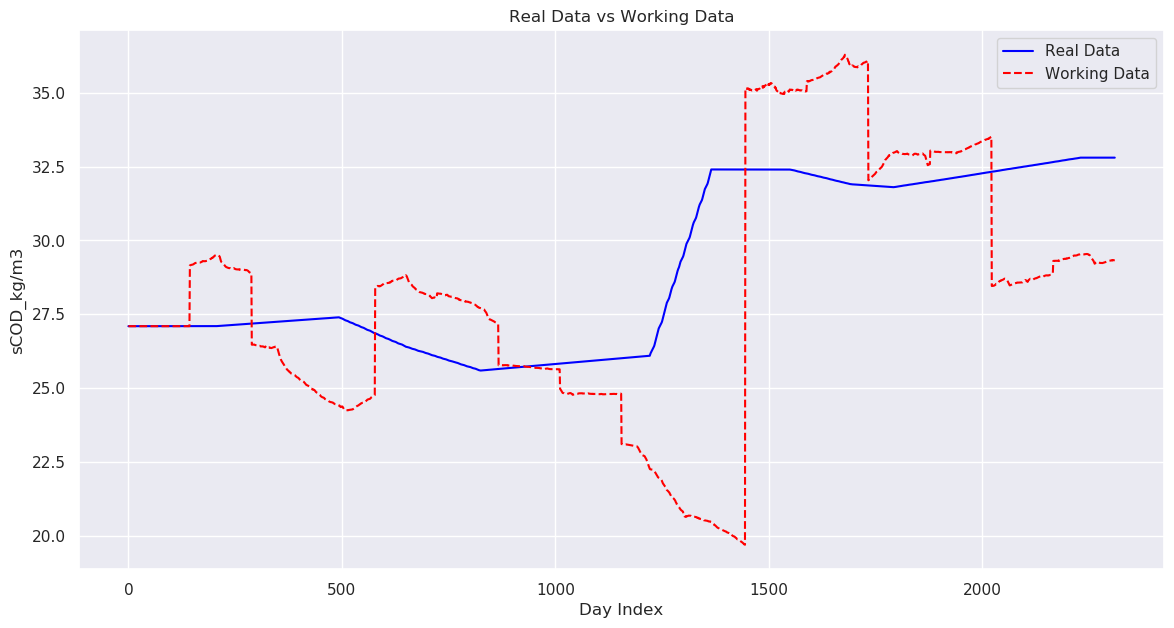

In [314]:


working_data = [item for sublist in tracking_df['working'].tolist() for item in sublist]
real_data = [item for sublist in tracking_df['real'].tolist() for item in sublist]

plt.figure(figsize=(14, 7))
plt.plot(real_data, label='Real Data', color='blue')
plt.plot(working_data, label='Working Data', color='red', linestyle='--')
plt.legend()
plt.title('Real Data vs Working Data')
plt.xlabel('Day Index')
plt.ylabel('sCOD_kg/m3')
plt.show()